### EDA

In [1]:
import pandas as pd
import geopandas as gpd
import ast,os,random
pd.set_option('display.float_format','{:.1f}'.format)
import warnings
warnings.filterwarnings('ignore')
import cudf, cupy as cp
import numpy as np
import time
import math
import pickle
import pyarrow.parquet as pq
import matplotlib.pyplot as plt


table = pq.read_table('../input/185/total_population_dataset.parquet')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 7.5 MB/s eta 0:00:0000:01


### データフレームの概要
2020年の総人口と，2010年からの移住に関する情報が記されたデータ

Net
- 1: Inward Migration（内部移住）
- 0: Stationary（定住）
- -1: Outward Migration（外部移住）

Race
- 0: All
- 1: White
- 2: African American
- 3: American Indian
- 4: Asian alone
- 5: Native Hawaiian
- 6: Other Race alone
- 7: Two or More


`0: all`がわからない
  `6: Other Race alone`や`7: Two or More`でも当てはまっていないということ？

County \
Mappings for counties can be found in id2county.pkl file from root directory. \
 county(群）のID
 
 easting/northing \
 緯度と経度

In [2]:
cdf = cudf.DataFrame.from_arrow(table)
cdf.head()

easting  northing  race  net  county
0 -9626792.0 3825189.8     1    0       0
1 -9626832.0 3825073.8     1    0       0
2 -9627101.0 3825153.5     1    0       0
3 -9627149.0 3825322.8     1    0       0
4 -9627159.0 3825334.8     1    0       0

cuXfilterの準備をする

In [3]:
import cudf
import cuxfilter

# cuXfilterのデータフレームを作成する
cux_df = cuxfilter.DataFrame(cdf)

試しに緯度経度の散布図をプロット。アメリカの国土のような図が出てくるはずである。人が住んでいるところを示しているので，まばらなところもある

In [ ]:
22.08-cuda11.0-py3.8

In [6]:
!nvidia-smi

Mon Sep 18 16:19:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.236.01   Driver Version: 450.236.01   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:20:00.0 Off |                    0 |
| N/A   43C    P0    37W / 250W |   5023MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import cuxfilter
import cudf

scatter_geo_chart = cuxfilter.charts.scatter(x='easting',
y='northing',tile_provider='CartoDark')

d = cux_df.dashboard([scatter_geo_chart])

scatter_geo_chart.view()

Card(sizing_mode='scale_width', title='Scatter plot f..., width=800)
    [0] HoloViews(DynamicMap, height=400, sizing_mode='stretch_both')

In [43]:
from cuxfilter.charts import scatter

scatter_chart = charts.scatter(x='easting', y='northing')

d = cux_df.dashboard([scatter_chart])
scatter_chart.view()

Card(sizing_mode='scale_width', title='Scatter plot f..., width=800)
    [0] HoloViews(DynamicMap, height=400, sizing_mode='stretch_both')

人が住んでいるところを示しているので，まばらなところもある

In [14]:
# 人種の分布

bar_chart_race = cuxfilter.charts.bar('race', data_points=5, add_interaction=False)

d = cux_df.dashboard([bar_chart_race])
#view the individual bar chart part of the dashboard d
#await d.preview()
bar_chart_race.view()

Card(sizing_mode='scale_width', title='race', width=400)
    [0] Bokeh(Figure)

In [93]:
# 人種と移住の関係

from cuxfilter import charts

race_net = charts.bar(x='race', y='net')
d = cux_df.dashboard([race_net])
race_net.view()

Card(sizing_mode='scale_width', title='race', width=400)
    [0] Bokeh(Figure, sizing_mode='stretch_both')
    [1] RangeSlider(end=7, sizing_mode='scale_width', step=1, value=(0, 7), value_end=7, width=400)

In [97]:
# countyのヒストグラム

county_hist = charts.bar('county')
d = cux_df.dashboard([county_hist])
county_hist.view()

Card(sizing_mode='scale_width', title='county', width=400)
    [0] Bokeh(Figure, sizing_mode='stretch_both')
    [1] RangeSlider(end=1954, sizing_mode='scale_width', step=1, value=(0, 1954), value_end=1954, width=400)

GPUメモリエラーが発生するため，`pandas`にして実行する

### panadasでデータ探索

cudfからpandasのデータフレームpdfへの変換

In [41]:
# pandasデータフレームへ変換
pdf = cdf.to_pandas()

pdf.head()

easting  northing  race  net  county
0 -9626792.0 3825189.8     1    0       0
1 -9626832.0 3825073.8     1    0       0
2 -9627101.0 3825153.5     1    0       0
3 -9627149.0 3825322.8     1    0       0
4 -9627159.0 3825334.8     1    0       0

それぞれのhistgram

<AxesSubplot:ylabel='Frequency'>

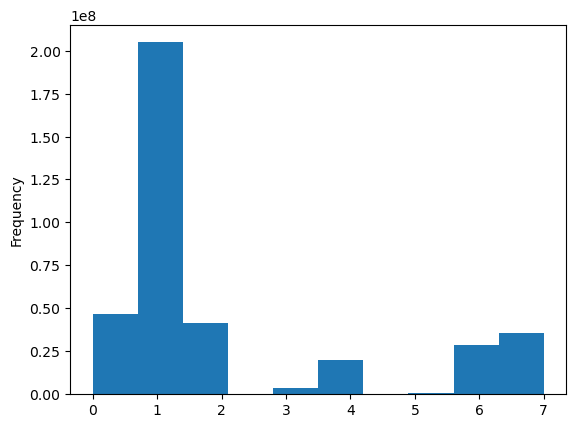

In [9]:
# raceのhistgram
import matplotlib.pyplot as plt

pdf['race'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

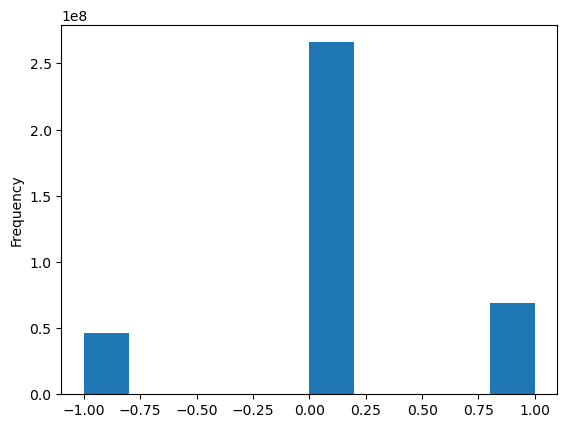

In [10]:
# netのhistgram
pdf['net'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

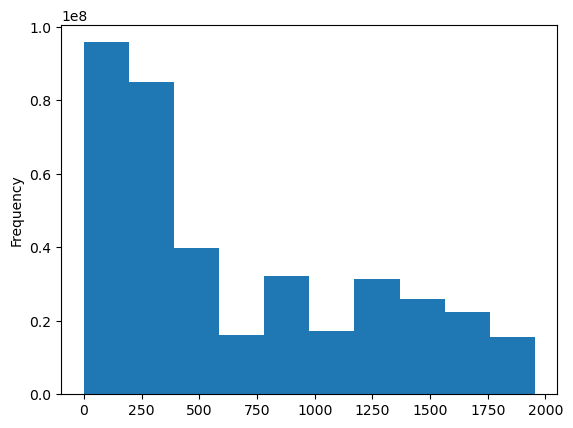

In [11]:
# countyのhistgram
pdf['county'].plot.hist()